# Cookie Cats

El dataset "Cookie Cats" (Kaggle) se centra en un juego móvil. Los datos tienen como objetivo ser usados en estudios de *engagement* de usuarios y pruebas A/B, lo que sugiere variables de comportamiento y retención. Entre las variables listadas, hay datos como:

- **userid**: Identificador del usuario, usado para diferenciar a cada jugador.
- **version**: Versión del juego que utilizo el usuario.
- **sum_gamerounds**: Total de rondas jugadas por el usuario, indicando el nivel de participación.
- **retention_1**: Indicador de retención del primer día, generalmente un valor booleano (1 = usuario regresó el día siguiente, 0 = no regresó).
- **retention_7**: Indicador de retención al séptimo día, mostrando si el usuario continúa activo después de una semana.

In [1]:
# librerias
library(dplyr) # manipulación y transformación de datos
library(MASS) # funciones de modelado estadístico
library(class) # algoritmos de clasificación


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [3]:
getwd() # Obtener el directorio de trabajo actual

[1] "/home/jovyan"

In [4]:
setwd("/home/jovyan/work/03") # Establecer el directorio de trabajo

In [5]:
### File import
raw_data <- read.csv(file="cookie_cats_user_engagement.csv", 
                     sep=",", 
                     head=TRUE) # Importar el archivo CSV como dataframe en raw_data

head(raw_data) # Mostrar las primeras filas de raw_data para revisión inicial

,userid,version,sum_gamerounds,retention_1,retention_7
,<int>,<chr>,<int>,<lgl>,<lgl>
1,116,gate_30,3,FALSE,FALSE
2,337,gate_30,38,TRUE,FALSE
3,377,gate_40,167,TRUE,FALSE
4,483,gate_40,2,FALSE,FALSE
5,488,gate_40,182,TRUE,TRUE
6,540,gate_40,190,TRUE,TRUE


Contamos y mostramos el número de observaciones en dos versiones distintas del dataset, *gate_30* y *gate_40*, y calcula el total de entradas.

In [3]:
# Contar el número de usuarios en la versión "gate_30" (grupo de referencia)
n_reference <- sum(raw_data$version == "gate_30")

# Contar el número de usuarios en la versión "gate_40" (grupo de prueba)
n_test <- sum(raw_data$version == "gate_40")

# Calcular el número total de usuarios (referencia + prueba)
n_total <- n_reference + n_test

# Imprimir el número de observaciones en el grupo de referencia
print(paste0("Number of reference values: ",n_reference))

# Imprimir el número de observaciones en el grupo de prueba
print(paste0("Number of test values: ",n_test))

# Imprimir el número total de observaciones
print(paste0("Total number of entries: ", n_total))


[1] "Number of reference values: 44700"
[1] "Number of test values: 45489"
[1] "Total number of entries: 90189"


Separamos el dataset en dos subconjuntos: uno para el grupo de referencia (gate_30) y otro para el grupo de prueba (gate_40), y visualizamos las primeras filas de cada uno.

In [4]:
# Filtramos los datos para crear el subset de referencia con usuarios "gate_30"
reference <- raw_data[grep("gate_30", raw_data$version),]

# Filtramos los datos para crear el subset de prueba con usuarios "gate_40"
test <- raw_data[grep("gate_40", raw_data$version),]

# Mostramos las primeras filas del subset de referencia
print(head(reference))

# Mostramos las primeras filas del subset de prueba
print(head(test))

   userid version sum_gamerounds retention_1 retention_7
1     116 gate_30              3       FALSE       FALSE
2     337 gate_30             38        TRUE       FALSE
7    1066 gate_30              0       FALSE       FALSE
12   2101 gate_30              0       FALSE       FALSE
14   2179 gate_30             39        TRUE       FALSE
15   2218 gate_30            305        TRUE        TRUE
  userid version sum_gamerounds retention_1 retention_7
3    377 gate_40            167        TRUE       FALSE
4    483 gate_40              2       FALSE       FALSE
5    488 gate_40            182        TRUE        TRUE
6    540 gate_40            190        TRUE        TRUE
8   1444 gate_40              5       FALSE       FALSE
9   1574 gate_40            111        TRUE        TRUE


Mostramos resúmenes estadísticos de los datos originales y de los subconjuntos de referencia y prueba para comparar sus características.

In [5]:
# Mostramos resumen estadístico del dataset completo
print(summary(raw_data))

# Mostramos resumen estadístico del subset de referencia
print(summary(reference))

# Mostramos resumen estadístico del subset de prueba
print(summary(test))

     userid          version          sum_gamerounds     retention_1    
 Min.   :    116   Length:90189       Min.   :    0.00   Mode :logical  
 1st Qu.:2512230   Class :character   1st Qu.:    6.00   FALSE:50036    
 Median :4995815   Mode  :character   Median :   18.00   TRUE :40153    
 Mean   :4998412                      Mean   :   52.88                  
 3rd Qu.:7496452                      3rd Qu.:   52.00                  
 Max.   :9999861                      Max.   :49854.00                  
 retention_7    
 Mode :logical  
 FALSE:73408    
 TRUE :16781    
                
                
                
     userid          version          sum_gamerounds     retention_1    
 Min.   :    116   Length:44700       Min.   :    0.00   Mode :logical  
 1st Qu.:2505469   Class :character   1st Qu.:    5.00   FALSE:24666    
 Median :4983631   Mode  :character   Median :   17.00   TRUE :20034    
 Mean   :4987564                      Mean   :   52.46                  
 3rd 

Filtramos el dataset para eliminar valores extremos en sum_gamerounds, manteniendo solo los valores menores o iguales al percentil 99, y vuelve a separar los datos en los subconjuntos de referencia y prueba

In [6]:
# Calculamos el percentil 99 de sum_gamerounds para definir el umbral de filtro
quantile(raw_data$sum_gamerounds, probs = c(0.01, 0.99))[2]

# Filtramos el dataset para mantener solo valores de sum_gamerounds <= 493
raw_data_filtered <- raw_data[raw_data$sum_gamerounds <= 493,]

# Creamos el subset de referencia filtrado con usuarios "gate_30"
reference <- raw_data_filtered[grep("gate_30", raw_data_filtered$version),]

# Creamos el subset de prueba filtrado con usuarios "gate_40"
test <- raw_data_filtered[grep("gate_40", raw_data_filtered$version),]

99% 
493.12

Generamos histogramas superpuestos de sum_gamerounds para comparar las distribuciones de los grupos de prueba y referencia.

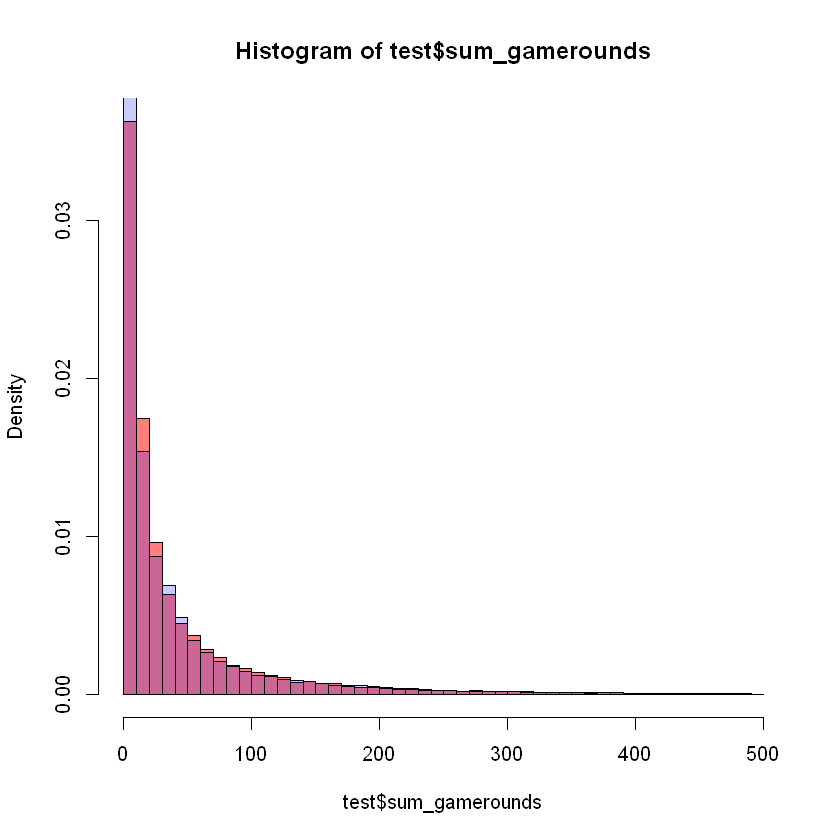

In [7]:
# Creamos un histograma para el grupo de prueba en color rojo semi-transparente
hist(test$sum_gamerounds, 
     col = rgb(1, 0, 0, 0.5), 
     breaks = seq(0, 500, 10), 
     probability = TRUE)

# Añadimos el histograma del grupo de referencia en azul semi-transparente
hist(reference$sum_gamerounds, 
     add = TRUE, 
     col = rgb(0, 0, 1, 0.2), 
     breaks = seq(0, 500, 10), 
     probability = TRUE)

Creamos una gráfica de densidad para comparar visualmente las distribuciones de sum_gamerounds en los grupos de referencia y prueba.

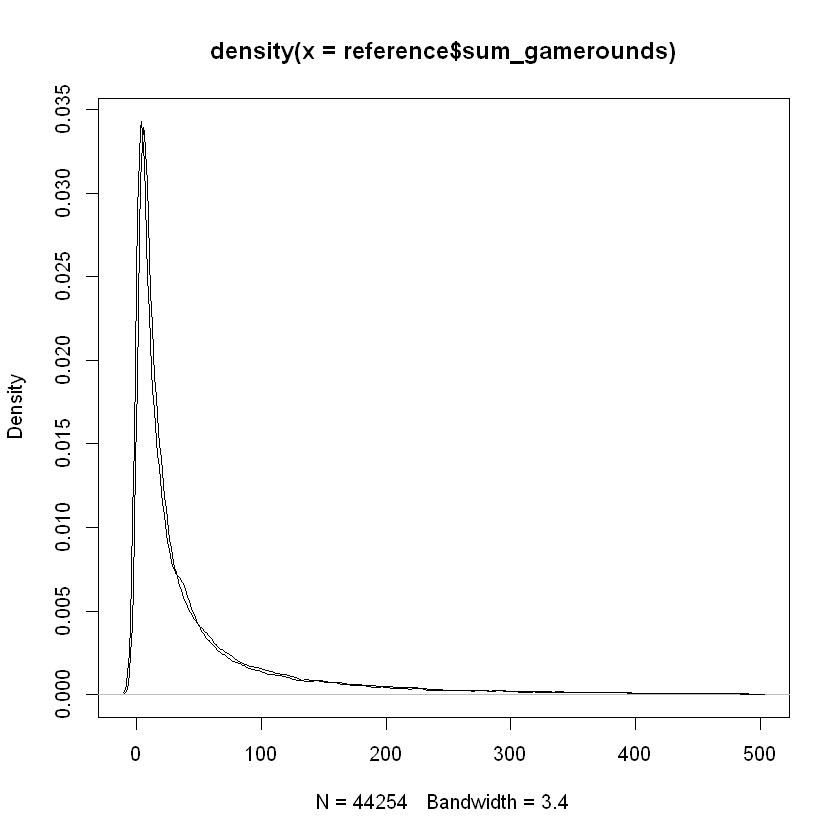

In [8]:
# Graficamos la densidad de sum_gamerounds para el grupo de referencia
plot(density(reference$sum_gamerounds))

# Añadimos la densidad de sum_gamerounds para el grupo de prueba
lines(density(test$sum_gamerounds))


Calculamos, guardamos y mostramos estadísticas descriptivas clave (media y desviación estándar) de sum_gamerounds para los grupos de prueba y referencia, y realiza un cálculo adicional relacionado con la varianza del grupo de referencia.

In [9]:
## Estadisticos:

# Calculamos la media de sum_gamerounds para el grupo de prueba
mean_test = mean(test$sum_gamerounds)

# Calculamos la media de sum_gamerounds para el grupo de referencia
mean_reference = mean(reference$sum_gamerounds)

# Calculamos la desviación estándar de sum_gamerounds para el grupo de prueba
sd_test = sd(test$sum_gamerounds)

# Calculamos la desviación estándar de sum_gamerounds para el grupo de referencia
sd_reference = sd(reference$sum_gamerounds)

# Calculamos la varianza del grupo de referencia dividida por su tamaño de muestra
sd_reference * sd_reference / n_reference

# Guardamos el tamaño de muestra del grupo de prueba
n_test = nrow(test)

# Guardamos el tamaño de muestra del grupo de referencia
n_reference = nrow(reference)

[1] 0.116362

Calculamos el valor de $Z$ para comparar las medias de sum_gamerounds entre los grupos de prueba y referencia, evaluando la significancia de la diferencia observada.

In [10]:
# Calculamos la diferencia de medias entre el grupo de prueba y el grupo de referencia
delta_mu = mean_test - mean_reference

# Calculamos el error estándar de la diferencia de medias
sd_delta_mu = sqrt((sd_reference * sd_reference) / n_reference + (sd_test * sd_test) / n_test)

# Imprimimos la diferencia de medias
print(delta_mu)

# Imprimimos el error estándar de la diferencia de medias
print(sd_delta_mu)

# Calculamos el estadístico Z dividiendo la diferencia de medias por su error estándar
z = delta_mu / sd_delta_mu

# Imprimimos el valor de Z
print(z)

[1] 1.698575
[1] 0.4804408
[1] 3.535451


- **Diferencia de medias** (delta_mu = 1.698575): Este valor indica la diferencia promedio de sum_gamerounds entre el grupo de prueba y el de referencia. Una diferencia positiva sugiere que el grupo de prueba tiene, en promedio, un mayor número de rondas de juego.

- **Error estándar de la diferencia de medias** (sd_delta_mu = 0.4804408): Este es el error estándar asociado a la diferencia de medias calculada. Representa la variabilidad esperada en la diferencia de medias entre ambos grupos debido al muestreo.

- **Estadístico Z** (z = 3.535451): Este valor Z cuantifica la magnitud de la diferencia de medias en términos del error estándar. Un valor de Z alto (como en este caso) indica que la diferencia observada entre las medias es significativa y poco probable que se deba al azar en muestras grandes.

<br>

## Uso de graficos ggstatsplot

In [11]:
if (!require("repr")) install.packages("repr")
library(repr)

# Ajusta el tamaño de los gráficos (por ejemplo, 10 pulgadas de ancho y 6 de alto)
options(repr.plot.width = 15, repr.plot.height = 10)

Cargando paquete requerido: repr



In [12]:
if (!require("ggstatsplot")) install.packages("ggstatsplot")
library(ggstatsplot)

if (!require("ggplot2")) install.packages("ggplot2")
library(ggplot2)  # Necesario para el uso de theme()

Cargando paquete requerido: ggstatsplot

You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167

Cargando paquete requerido: ggplot2



### Ejemplo 1

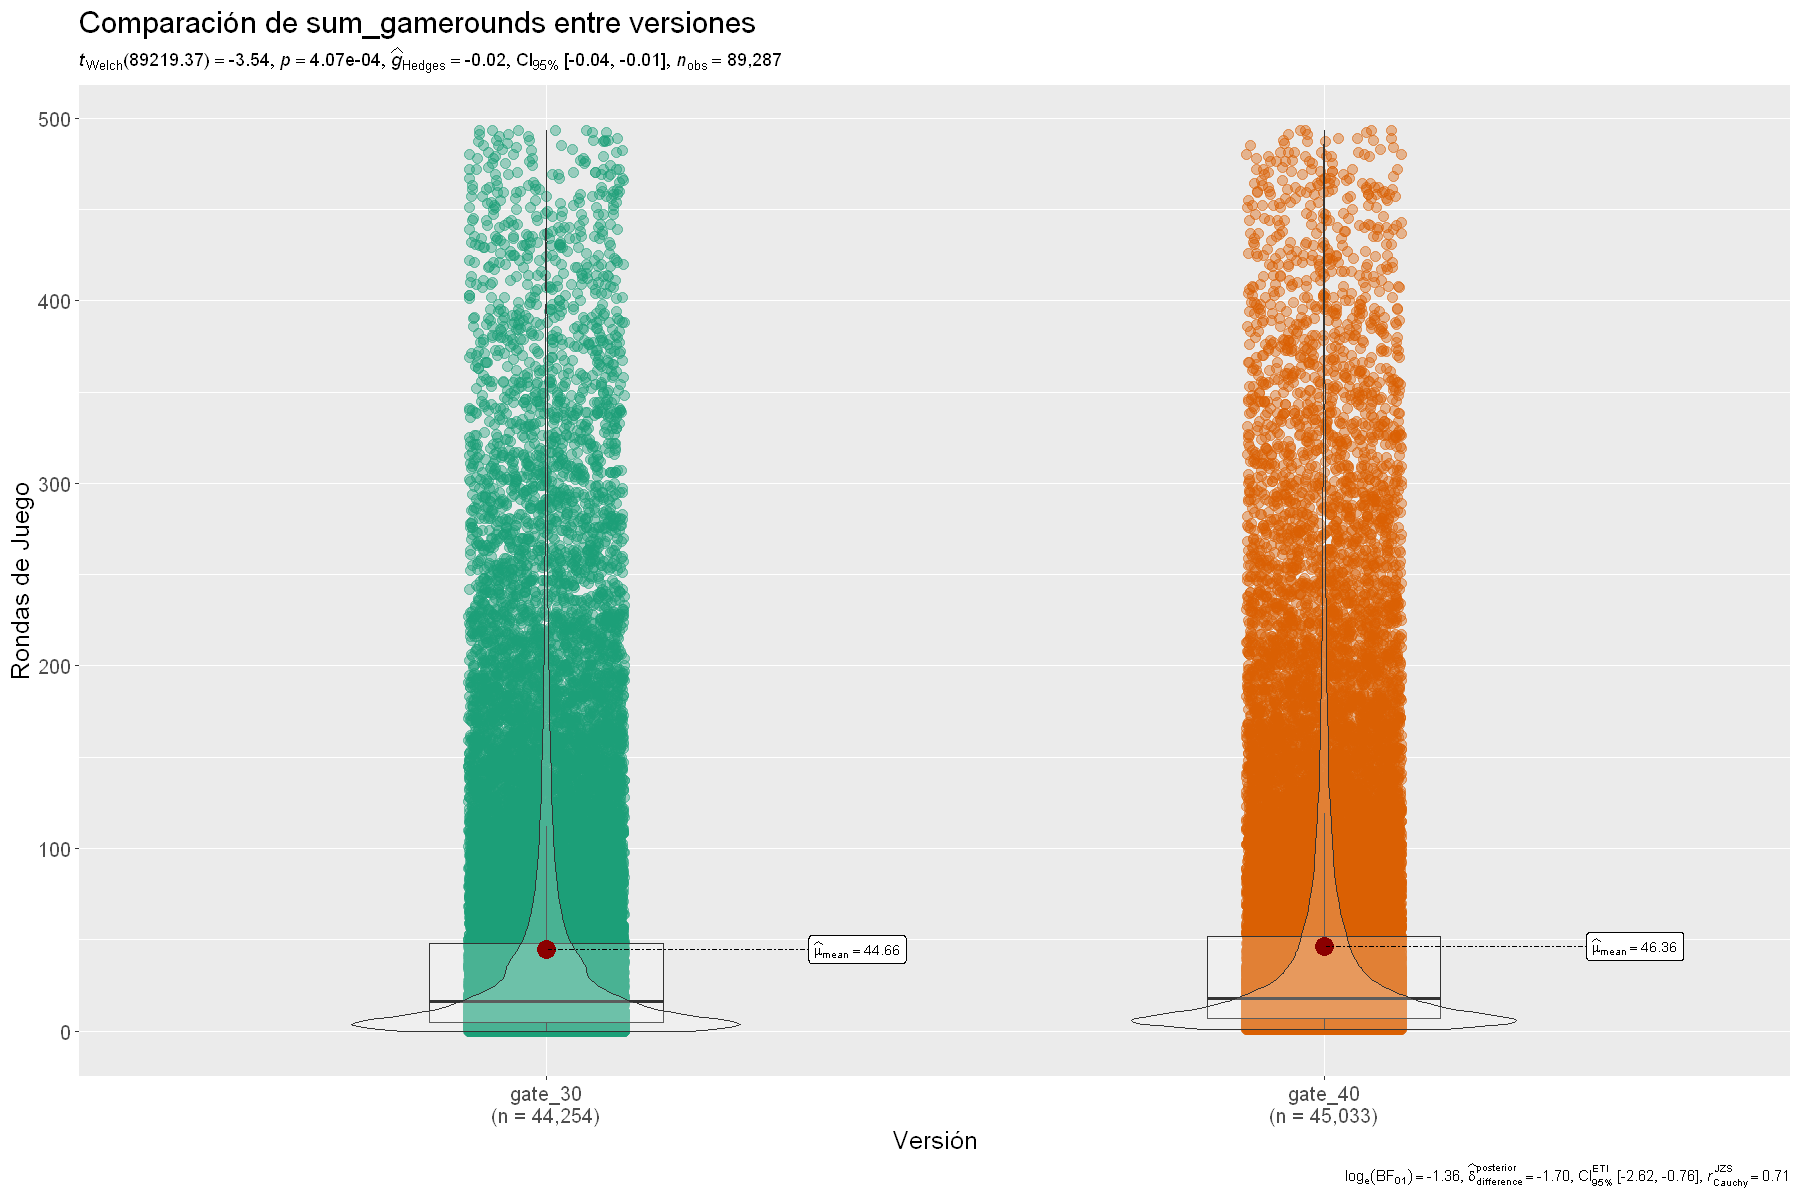

In [13]:
# Graficar comparación entre los grupos "gate_30" y "gate_40" con eje y limitado

ggbetweenstats(
  data = raw_data_filtered, 
  x = version,
  y = sum_gamerounds,
  title = "Comparación de sum_gamerounds entre versiones",
  xlab = "Versión",
  ylab = "Rondas de Juego",
  ggtheme = theme(
    plot.title = element_text(size = 18),      # Tamaño del título
    axis.title = element_text(size = 15),      # Tamaño de los nombres de ejes
    axis.text = element_text(size = 12),       # Tamaño del texto en los ejes
    legend.title = element_text(size = 14),    # Tamaño del título de la leyenda
    legend.text = element_text(size = 12)      # Tamaño del texto de la leyenda
  )
)

La prueba *t de Welch* es una variación de la prueba t de Student que se utiliza cuando se comparan las medias de dos grupos y se asume que sus varianzas pueden ser diferentes. Esta prueba es ideal para situaciones donde las siguientes condiciones pueden no cumplirse:

- Varianzas desiguales entre los grupos.
- Tamaños de muestra diferentes entre los grupos.

**Conclusiones del Gráfico de Comparación de `sum_gamerounds` entre Versiones**

**Distribución de `sum_gamerounds`**:
   - En el gráfico de violín, observamos la distribución de `sum_gamerounds` (rondas de juego) en los grupos `gate_30` y `gate_40`.
   - Ambas versiones (`gate_30` y `gate_40`) presentan una concentración de valores cercanos a 0, con una cola que se extiende hacia arriba, indicando que la mayoría de los usuarios juega solo unas pocas rondas, mientras que algunos usuarios juegan significativamente más rondas.

**Medias de los Grupos**:
   - La media de `sum_gamerounds` para `gate_30` es aproximadamente 44.66, mientras que para `gate_40` es 46.38. Esto indica una diferencia leve en la media de rondas de juego entre los dos grupos.
   
**Resultados Estadísticos**:
   - El valor $t$ de Welch, el valor $p$, y el intervalo de confianza se muestran en el subtítulo del gráfico.
   - Dado que $p = 4.07 \times 10^{-4}$, esta diferencia es estadísticamente significativa al nivel de significancia convencional (por ejemplo, \( \alpha = 0.05 \)).
   - Aunque la diferencia es significativa, el tamaño del efecto (\( \hat{d}_{Hedges} \approx -0.02 \)) es muy pequeño, lo que sugiere que, aunque la diferencia en medias es estadísticamente significativa, no es lo suficientemente grande como para tener un impacto relevante en términos prácticos.

**Interpretación Final**:
   - La versión `gate_40` tiene una media de rondas de juego ligeramente superior a la versión `gate_30`, pero la magnitud de esta diferencia es muy pequeña.
   - Este resultado implica que el cambio entre versiones (`gate_30` a `gate_40`) puede tener un efecto significativo en el comportamiento de los usuarios en términos de rondas jugadas, aunque el impacto práctico de este cambio es mínimo. 

### Ejemplo 2

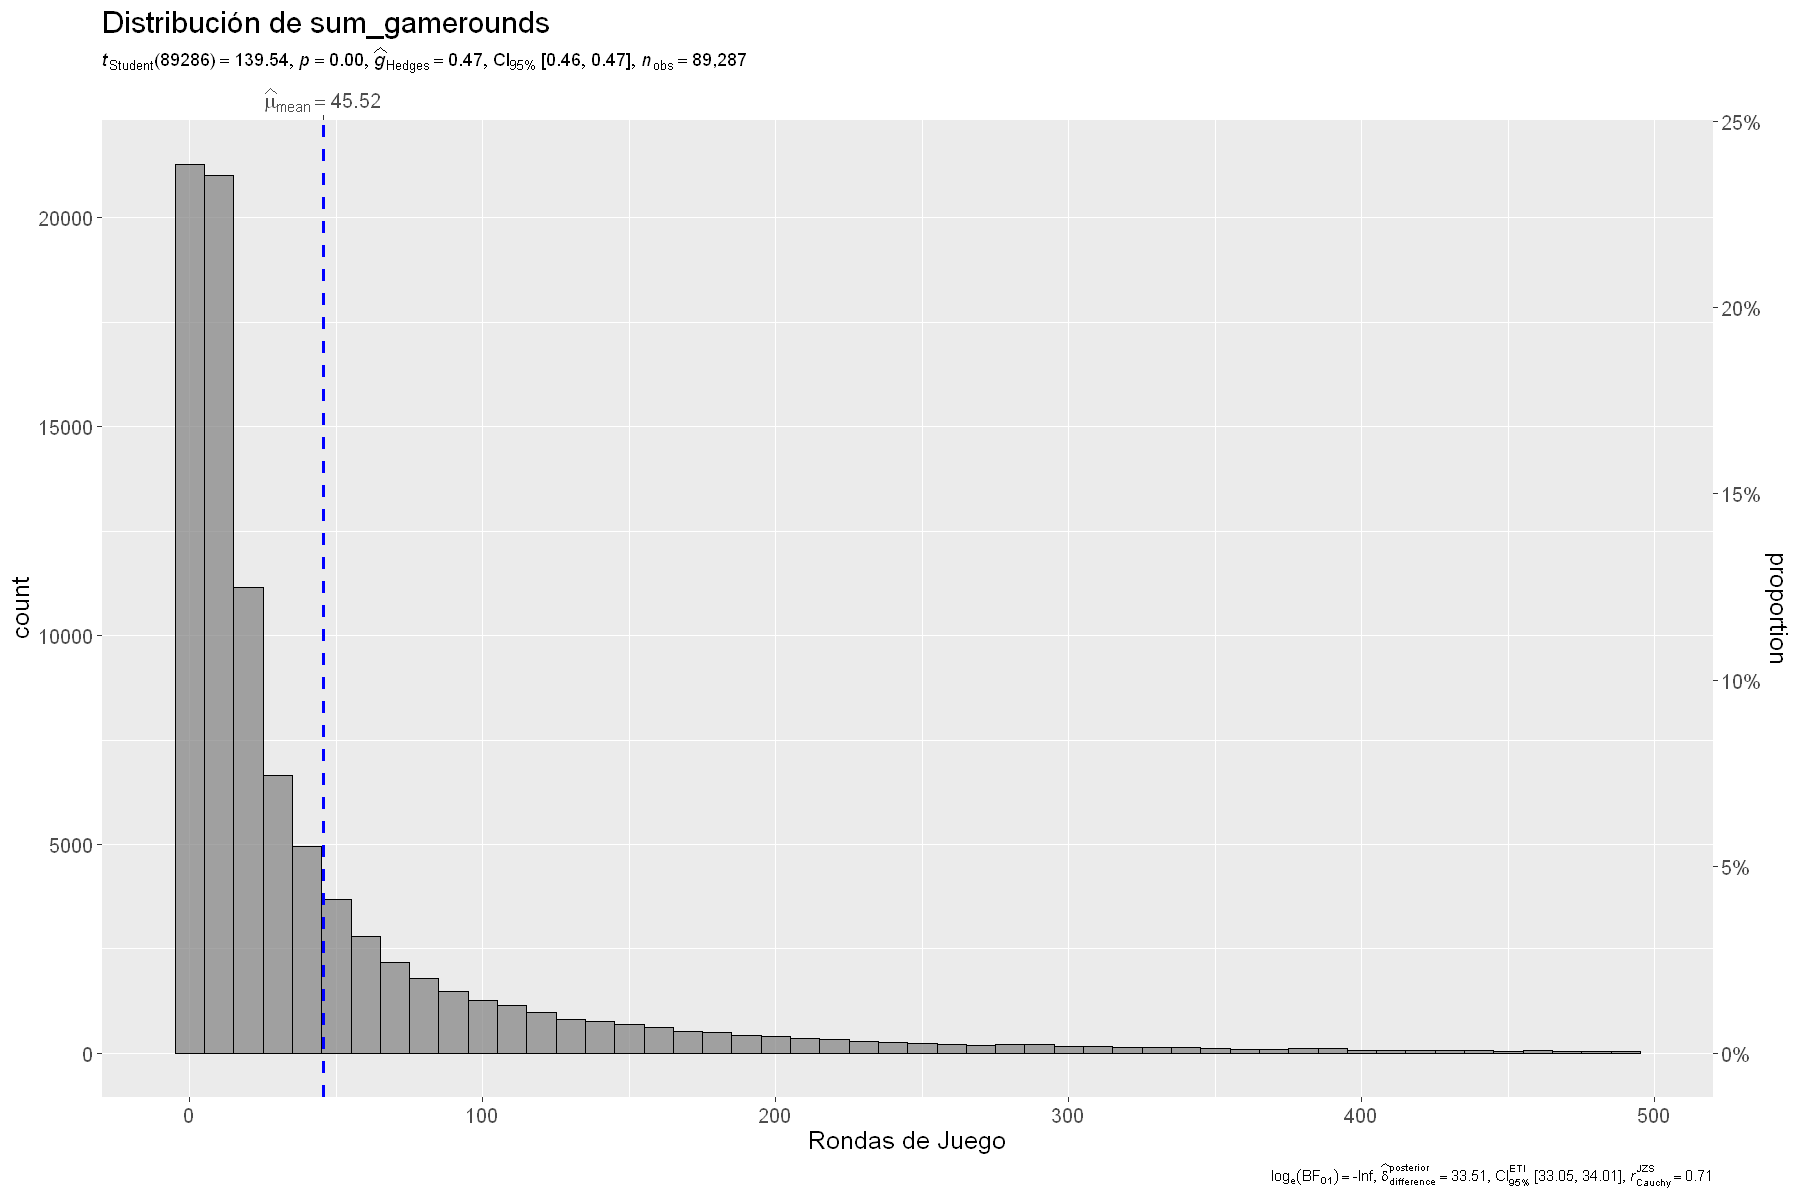

In [14]:
gghistostats(
  data = raw_data_filtered,
  x = sum_gamerounds,
  test.value = 12, # Valor de referencia
  ggsignif.args = list(textsize = 10, tip_length = 0.1),
  title = "Distribución de sum_gamerounds",
  xlab = "Rondas de Juego",
  binwidth = 10,
  ggtheme = theme(
    plot.title = element_text(size = 18),
    axis.title = element_text(size = 15),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )
)

**Distribución de `sum_gamerounds`**:
   - La variable `sum_gamerounds` muestra una distribución fuertemente sesgada a la derecha (asimetría positiva). La mayoría de los usuarios juegan pocas rondas, y la frecuencia decrece rápidamente a medida que aumentan las rondas jugadas.
   - Esto sugiere que la mayoría de los jugadores tienen una baja interacción en términos de rondas jugadas, mientras que un pequeño grupo juega muchas rondas.

**Prueba de Hipótesis (Comparación con un Valor de Referencia)**:
   - La línea vertical azul representa el valor promedio de rondas jugadas en la muestra (`mean = 45.52`), que es significativamente mayor que el valor de referencia (12) especificado en `test.value`.
   - En el subtítulo del gráfico, se muestra el resultado de una prueba t de Student para comparar si el promedio de `sum_gamerounds` es significativamente diferente de 12.
   - La prueba reporta un valor de \( t \) elevado (139.54) con un valor \( p \) cercano a 0, lo cual indica que la media observada es **significativamente mayor** que el valor de referencia de 12. Esto confirma que, en promedio, los usuarios juegan considerablemente más de 12 rondas.

**Tamaño del Efecto**:
   - El tamaño del efecto $\hat{d}_{Hedges} = 0.47$ es moderado, lo cual indica que la diferencia entre la media observada y el valor de referencia es no solo estadísticamente significativa sino también relevante en términos prácticos.

**Intervalo de Confianza**:
   - El intervalo de confianza al 95% para el tamaño del efecto, \([0.46, 0.47]\), es muy estrecho. Esto sugiere una alta precisión en la estimación del efecto, probablemente debido al gran tamaño de la muestra.

### Interpretación Final
Este análisis sugiere que los jugadores en este conjunto de datos tienen un nivel de interacción significativamente mayor que el valor de referencia de 12 rondas. La distribución sesgada indica que, aunque la mayoría de los usuarios juegan pocas rondas, el promedio es elevado debido a un grupo de jugadores con una interacción mucho más alta.


### Ejemplo 3

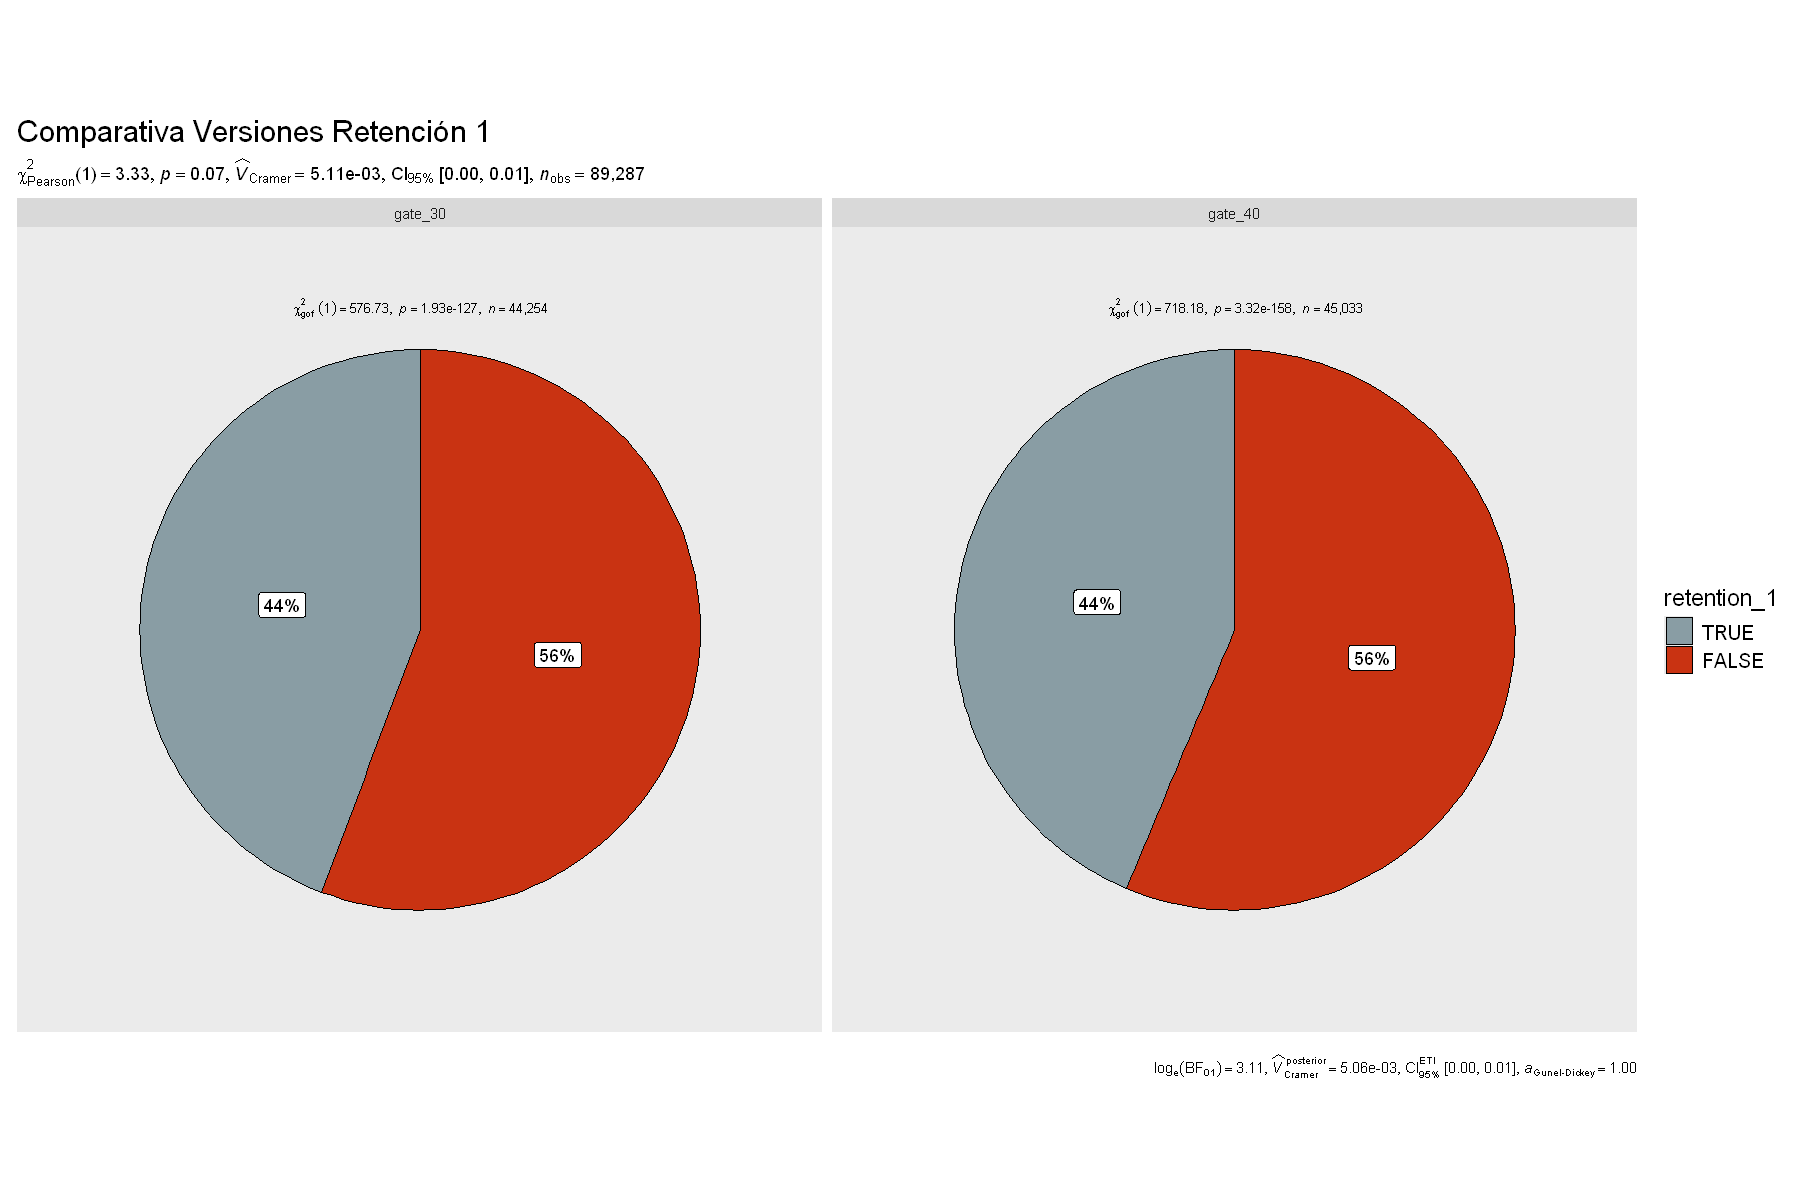

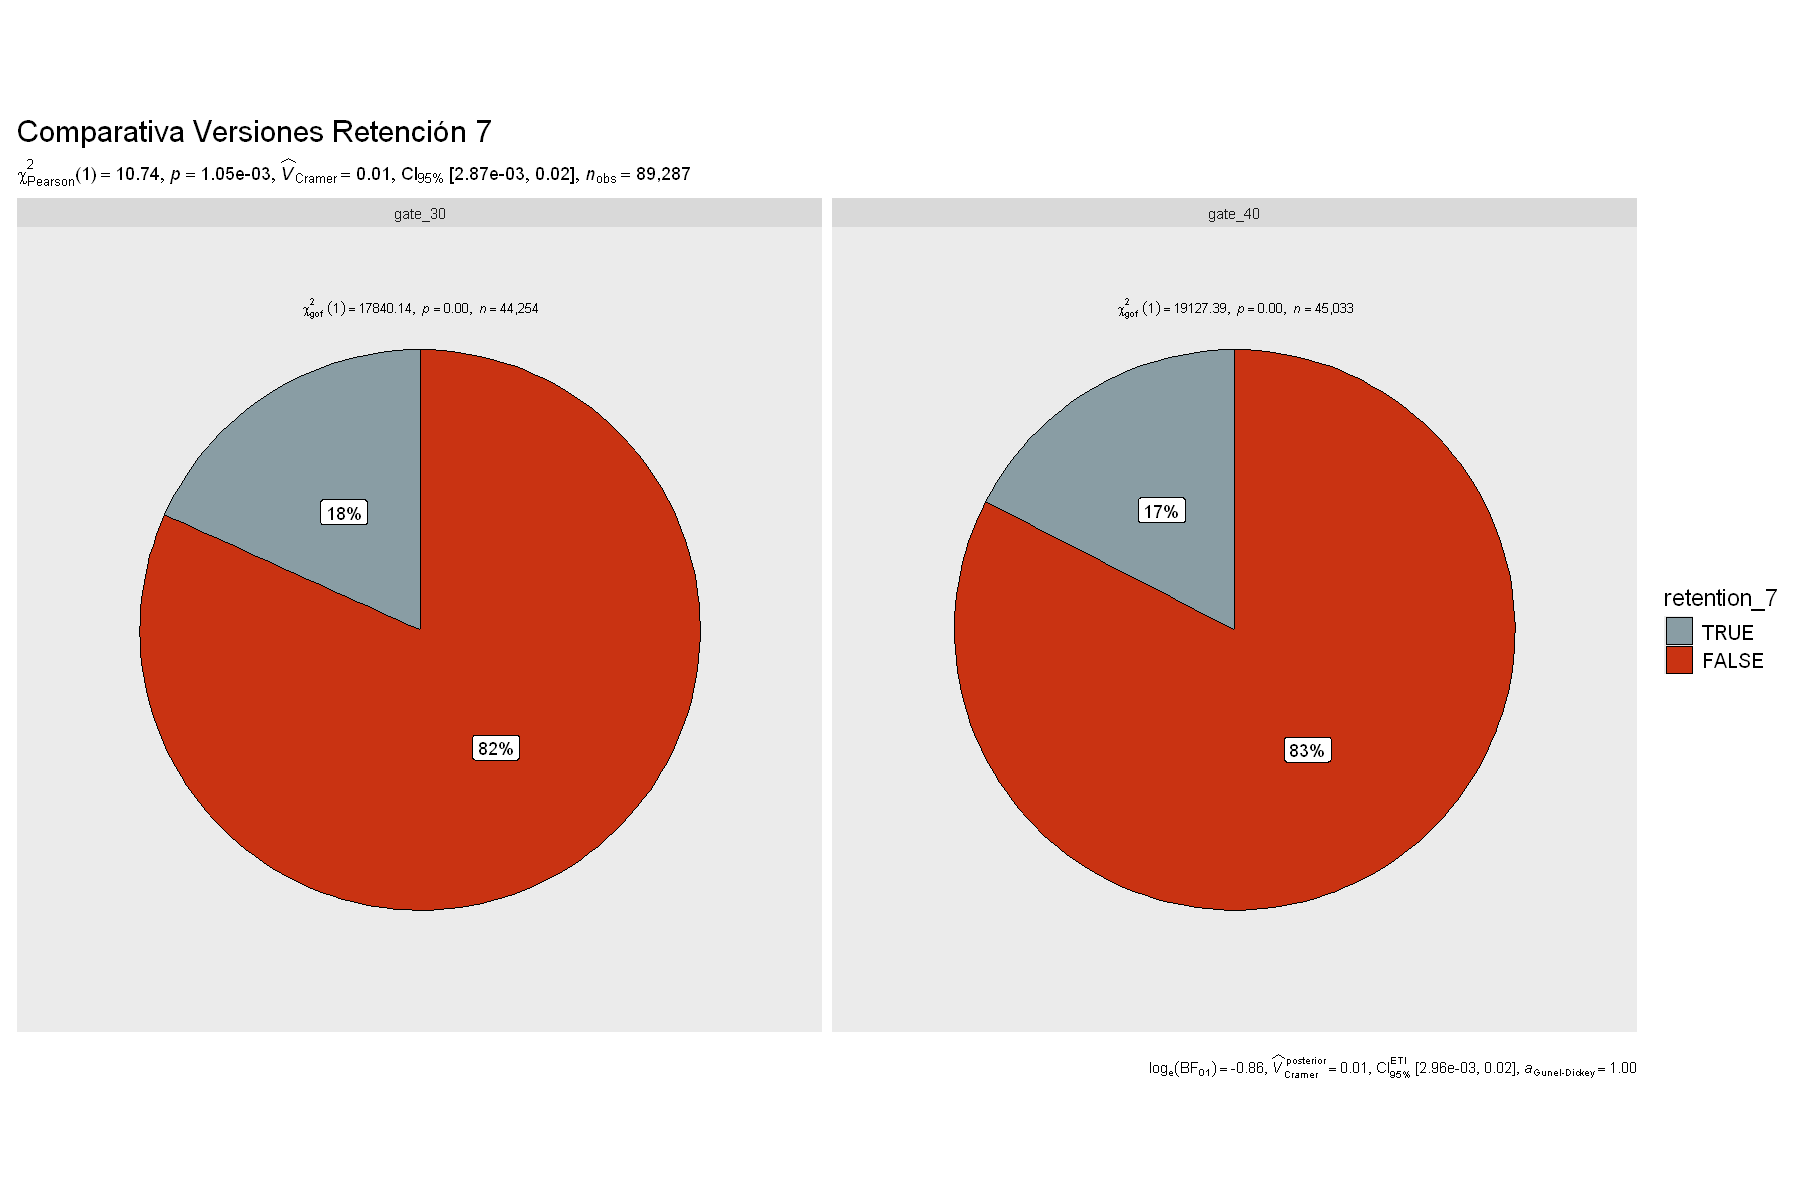

In [15]:
ggpiestats(
  data = raw_data_filtered,
  x = retention_1,
  y = version,
  package = "wesanderson",
  palette = "Royal1",
  title = "Comparativa Versiones Retención 1",
  legend.title = "retention_1",
  ggtheme = theme(
    plot.title = element_text(size = 18),
    axis.title = element_text(size = 15),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )
)


ggpiestats(
  data = raw_data_filtered,
  x = retention_7,
  y = version,
  package = "wesanderson",
  palette = "Royal1",
  title = "Comparativa Versiones Retención 7",
  legend.title = "retention_7",
  ggtheme = theme(
    plot.title = element_text(size = 18),
    axis.title = element_text(size = 15),
    axis.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )
)

La prueba de chi-cuadrado de Pearson se utiliza en este caso porque estamos evaluando la asociación entre dos variables categóricas: la versión del juego (gate_30 vs gate_40) y la retención de los usuarios (TRUE vs FALSE).

**Gráfico A: Retención Día 1 (`retention_1`)**

**Distribución de la Retención**:
   - En ambas versiones (`gate_30` y `gate_40`), el porcentaje de usuarios que regresaron el día 1 (`retention_1 = TRUE`) es del 44%, mientras que el 56% no regresó (`retention_1 = FALSE`).
   - Esta similitud sugiere que el cambio de versión (`gate_30` a `gate_40`) **no parece influir** en la retención del primer día.

**Prueba de Hipótesis (Chi-cuadrado)**:
   - En el panel superior, el test de **chi-cuadrado** reporta un valor de $\chi^2$ de 3.33 con un valor $p = 0.07$.
   - Este valor $p$ sugiere que no hay una diferencia estadísticamente significativa en la retención entre las dos versiones en el día 1. Por lo tanto, la versión del juego **no tiene un impacto significativo** en la retención temprana (día 1).

**Gráfico 2: Retención Día 7 (`retention_7`)**

**Distribución de la Retención**:
   - En este caso, tanto en `gate_30` como en `gate_40`, el porcentaje de usuarios que regresaron el día 7 (`retention_7 = TRUE`) es considerablemente menor que los que no regresaron.
   - La retención para `retention_7 = TRUE` es de 18% en `gate_30` y de 17% en `gate_40`, mientras que el 82-83% de los usuarios en ambos grupos no regresó.

**Prueba de Hipótesis (Chi-cuadrado)**:
   - Para la retención en el día 7, la prueba de chi-cuadrado da un valor de $\chi^2$ de 10.74 con un $p = 1.05 \times 10^{-3}$.
   - Este valor $p$ es significativamente bajo, indicando una diferencia estadísticamente significativa en la retención del día 7 entre `gate_30` y `gate_40`. Sin embargo, dado que las proporciones son similares (17% vs 18%), la diferencia práctica es mínima, aunque es estadísticamente significativa debido al gran tamaño de la muestra.

**Interpretación Final**

- **Retención Día 1**: No hay una diferencia significativa en la retención entre `gate_30` y `gate_40`. La proporción de usuarios que regresa el día 1 es similar en ambas versiones.
- **Retención Día 7**: Aunque se detecta una diferencia estadísticamente significativa en la retención entre las versiones, esta diferencia es muy pequeña en términos prácticos (17% vs 18%). Esto sugiere que el cambio de versión tiene un efecto mínimo sobre la retención a largo plazo.

En conclusión, **el cambio de versión (`gate_30` a `gate_40`) no tiene un impacto relevante en la retención del primer día ni en la retención a largo plazo (día 7)**, aunque estadísticamente se observa una pequeña diferencia en el día 7.

<br>

**Nota**: Para mas información referente a *ggstatsplot* consultar el siguiente enlaze $\rightarrow$ https://indrajeetpatil.github.io/ggstatsplot/

<br>